We'll be using this notebook for data processing and exploration.
We'll load the processed data into a DataViz software to better visualize patterns and extract insights 

# Loading necessary packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

# Disabling all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Loading dataset and converting data columns to datetime format

In [2]:
df = pd.read_csv('logistic-case-v4.csv')

In [3]:
date_columns = [col for col in df.columns if '_at' in col] + ['delivery_estimate_date']

for col in date_columns:
    df[col] = pd.to_datetime(df[col])

# Missing values analysis

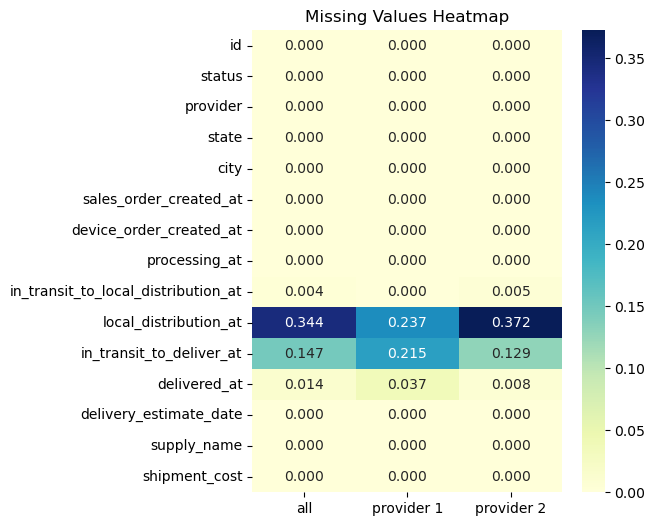

In [4]:
missing_values_df = pd.DataFrame()
missing_values_df.index = df.isna().mean().index
missing_values_df['all'] = df.isna().mean().values
missing_values_df['provider 1'] = df[df['provider'] == 'provider 1'].isna().mean().values
missing_values_df['provider 2'] = df[df['provider'] == 'provider 2'].isna().mean().values

plt.figure(figsize=(5, 6))

sns.heatmap(missing_values_df, cmap='YlGnBu', annot=True, fmt=".3f")

plt.title('Missing Values Heatmap')

plt.show()

- The count of missing values is very high for both local_distribution_at and in_transit_to_deliver_at timestamps
- The faulty values count is not necessarily different between the providers

# Creating additional features

Extracting extra feature from the dataset in order to generate more impactful KPIS

- Missing tracking (since it seems ok to skip the 'local_distribution_at' step we will not consider missing values in this column as tracking errors)
- Brazillian UF to Macrorregion
- Logistics steps transition time
- on_time, delivered, returned, estimated_delivery_time and actual_develiry time indicators

In [5]:
df['missing_tracking'] = df.drop('local_distribution_at', axis = 1).isna().sum(axis = 1) > 0

In [6]:
brazilian_state_regions = {
    'AC': 'North',
    'AL': 'Northeast',
    'AP': 'North',
    'AM': 'North',
    'BA': 'Northeast',
    'CE': 'Northeast',
    'DF': 'Central-West',
    'ES': 'Southeast',
    'GO': 'Central-West',
    'MA': 'Northeast',
    'MT': 'Central-West',
    'MS': 'Central-West',
    'MG': 'Southeast',
    'PA': 'North',
    'PB': 'Northeast',
    'PR': 'South',
    'PE': 'Northeast',
    'PI': 'Northeast',
    'RJ': 'Southeast',
    'RN': 'Northeast',
    'RS': 'South',
    'RO': 'North',
    'RR': 'North',
    'SC': 'South',
    'SP': 'Southeast',
    'SE': 'Northeast',
    'TO': 'North'
}

df['region'] = df['state'].replace(brazilian_state_regions)

In [7]:
def calc_time_diff(col1, col2):
    return (df[col2] - df[col1]).apply(lambda x: x.total_seconds() / (86400))

time_delta_cols = []
for i in range(len(date_columns) - 2):
    col1_name = date_columns[i].split('_')
    col1_name = '_'.join(col1_name[:-1])
    col2_name = date_columns[i + 1].split('_')
    col2_name = '_'.join(col2_name[:-1])
    df[col1_name + '_to_' + col2_name + '_days'] = calc_time_diff(date_columns[i], date_columns[i+1])
    
    time_delta_cols.append(col1_name + '_to_' + col2_name + '_days')

df  

,id,status,provider,state,city,sales_order_created_at,device_order_created_at,processing_at,in_transit_to_local_distribution_at,local_distribution_at,...,supply_name,shipment_cost,missing_tracking,region,sales_order_created_to_device_order_created_days,device_order_created_to_processing_days,processing_to_in_transit_to_local_distribution_days,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days
0,1,delivered,provider 2,SP,Nova Granada,2023-02-14 23:00:19.249213,2023-02-14 23:30:08.644443,2023-02-14 23:30:11.106779,2023-02-15 02:36:22,NaT,...,infiniteblack p2,12.83,False,Southeast,0.020711,0.000028,0.129293,NaN,NaN,0.852951
1,2,delivered,provider 2,DF,Brasília,2023-01-06 21:07:58.330363,2023-01-06 22:30:46.118321,2023-01-06 22:31:08.448257,2023-01-07 01:36:38,NaT,...,infiniteblack p2,38.96,False,Central-West,0.057498,0.000258,0.128814,NaN,NaN,0.332593
2,3,delivered,provider 2,PR,São José dos Pinhais,2023-01-07 03:21:52.617944,2023-01-07 03:45:08.598283,2023-01-07 03:45:12.637117,2023-01-07 06:54:14,NaT,...,infiniteblack p2,14.56,False,South,0.016157,0.000047,0.131266,NaN,NaN,0.380613
3,4,delivered,provider 2,RJ,Duque de Caxias,2023-01-07 18:23:09.397677,2023-01-07 18:45:07.727814,2023-01-07 18:45:22.393482,2023-01-07 21:54:27,NaT,...,infiniteblack p2,14.35,False,Southeast,0.015258,0.000170,0.131303,NaN,NaN,0.236123
4,5,delivered,provider 2,RJ,Rio de Janeiro,2023-01-09 18:53:46.044271,2023-01-09 19:15:09.233285,2023-01-09 19:15:12.665212,2023-01-09 22:27:26,NaT,...,infiniteblack p2,17.14,False,Southeast,0.014852,0.000040,0.133488,NaN,NaN,0.287500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42705,42706,delivered,provider 1,MG,Belo Horizonte,2023-02-26 12:08:39.365867,2023-02-26 12:30:06.497087,2023-02-26 12:30:09.063809,2023-02-27 11:55:30,2023-03-03 21:50:22,...,infiniteblack p2,14.77,False,Southeast,0.014897,0.000030,0.975937,4.413102,7.295058,0.412326
42706,42707,delivered,provider 1,RS,Caxias do Sul,2022-11-16 15:05:51.935526,2022-11-16 15:30:06.121532,2022-11-16 15:30:18.544899,2022-11-16 13:07:36,2022-11-29 10:28:09,...,infiniteblack p2,25.41,False,South,0.016831,0.000144,-0.099104,12.889271,1.273692,0.815093
42707,42708,delivered,provider 1,RN,Itaú,2022-12-13 21:31:15.512029,2022-12-13 21:45:07.515082,2022-12-13 21:45:10.012720,2022-12-14 09:50:54,NaT,...,infiniteblack p2,29.42,True,Northeast,0.009630,0.000029,0.503981,NaN,NaN,NaN
42708,42709,delivered,provider 1,MG,Uberaba,2022-11-08 20:09:40.801160,2022-11-08 20:30:15.065005,2022-11-08 20:30:16.976260,2022-11-09 12:03:16,2022-11-11 08:00:28,...,infiniteblack p2,16.25,False,Southeast,0.014285,0.000022,0.647905,1.831389,0.055046,0.048102


In [8]:
df['on_time'] = (df['delivered_at'] <= df['delivery_estimate_date']).astype(int)
df['delivered'] = (df['status'] == 'delivered').astype(int)
df['returned'] = (df['status'] == 'returned').astype(int)
df['estimated_delivery_time'] = calc_time_diff('sales_order_created_at', 'delivery_estimate_date')
df['delivery_time'] = calc_time_diff('sales_order_created_at', 'delivered_at')

# Evaluating data quality

Creating an additional column to indicate whether there are inconsistencies in the timestamps e.g.: transition times lesser than 0.

In [9]:
df['timestamp_error'] = False
for col in time_delta_cols:
    test = df[col] < 0
    df['timestamp_error'] = df['timestamp_error'] | test

df['tracking_error'] = (df['missing_tracking'] | df['timestamp_error']).astype(int)
df['timestamp_error'] = df['timestamp_error'].astype(int)
df['missing_tracking'] = df['missing_tracking'].astype(int)
df

,id,status,provider,state,city,sales_order_created_at,device_order_created_at,processing_at,in_transit_to_local_distribution_at,local_distribution_at,...,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days,on_time,delivered,returned,estimated_delivery_time,delivery_time,timestamp_error,tracking_error
0,1,delivered,provider 2,SP,Nova Granada,2023-02-14 23:00:19.249213,2023-02-14 23:30:08.644443,2023-02-14 23:30:11.106779,2023-02-15 02:36:22,NaT,...,NaN,NaN,0.852951,1,1,0,14.041444,3.986351,0,0
1,2,delivered,provider 2,DF,Brasília,2023-01-06 21:07:58.330363,2023-01-06 22:30:46.118321,2023-01-06 22:31:08.448257,2023-01-07 01:36:38,NaT,...,NaN,NaN,0.332593,1,1,0,11.119464,5.048075,0,0
2,3,delivered,provider 2,PR,São José dos Pinhais,2023-01-07 03:21:52.617944,2023-01-07 03:45:08.598283,2023-01-07 03:45:12.637117,2023-01-07 06:54:14,NaT,...,NaN,NaN,0.380613,1,1,0,9.859808,4.788419,0,0
3,4,delivered,provider 2,RJ,Duque de Caxias,2023-01-07 18:23:09.397677,2023-01-07 18:45:07.727814,2023-01-07 18:45:22.393482,2023-01-07 21:54:27,NaT,...,NaN,NaN,0.236123,1,1,0,12.233919,4.162530,0,0
4,5,delivered,provider 2,RJ,Rio de Janeiro,2023-01-09 18:53:46.044271,2023-01-09 19:15:09.233285,2023-01-09 19:15:12.665212,2023-01-09 22:27:26,NaT,...,NaN,NaN,0.287500,1,1,0,7.212662,2.141273,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42705,42706,delivered,provider 1,MG,Belo Horizonte,2023-02-26 12:08:39.365867,2023-02-26 12:30:06.497087,2023-02-26 12:30:09.063809,2023-02-27 11:55:30,2023-03-03 21:50:22,...,4.413102,7.295058,0.412326,0,1,0,11.493989,13.111350,0,0
42706,42707,delivered,provider 1,RS,Caxias do Sul,2022-11-16 15:05:51.935526,2022-11-16 15:30:06.121532,2022-11-16 15:30:18.544899,2022-11-16 13:07:36,2022-11-29 10:28:09,...,12.889271,1.273692,0.815093,0,1,0,7.370927,14.895927,1,1
42707,42708,delivered,provider 1,RN,Itaú,2022-12-13 21:31:15.512029,2022-12-13 21:45:07.515082,2022-12-13 21:45:10.012720,2022-12-14 09:50:54,NaT,...,NaN,NaN,NaN,1,1,0,14.103293,7.787320,0,1
42708,42709,delivered,provider 1,MG,Uberaba,2022-11-08 20:09:40.801160,2022-11-08 20:30:15.065005,2022-11-08 20:30:16.976260,2022-11-09 12:03:16,2022-11-11 08:00:28,...,1.831389,0.055046,0.048102,1,1,0,12.159944,2.596750,0,0


# Inputing missing values

Inputing faulty values using the median of transition time for the given city or state.

The algorithm will first try to fill the values with the city data (more specific).
If there is no city median available the program will then fill the values with the state median (less specific).

In [10]:
group_dict = {}
for col in time_delta_cols:
    group_dict[col] = 'median'

join_cols = ['provider','state', 'city']
city_grouped = df.groupby(join_cols).agg(group_dict).reset_index()
city_level_replace = pd.merge(df.drop(time_delta_cols, axis = 1), 
                              city_grouped, how = 'left', left_on = join_cols, right_on = join_cols)


join_cols = ['provider','state']
state_grouped = state_level_replace = df.groupby(join_cols).agg(group_dict).reset_index()
state_level_replace = pd.merge(df.drop(time_delta_cols, axis = 1), 
                              state_grouped, how = 'left', left_on = join_cols, right_on = join_cols)
for col in time_delta_cols:
    df[col] = df[col].fillna(city_level_replace[col])
    df[col] = df[col].fillna(state_level_replace[col])
df

,id,status,provider,state,city,sales_order_created_at,device_order_created_at,processing_at,in_transit_to_local_distribution_at,local_distribution_at,...,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days,on_time,delivered,returned,estimated_delivery_time,delivery_time,timestamp_error,tracking_error
0,1,delivered,provider 2,SP,Nova Granada,2023-02-14 23:00:19.249213,2023-02-14 23:30:08.644443,2023-02-14 23:30:11.106779,2023-02-15 02:36:22,NaT,...,1.827251,0.929867,0.852951,1,1,0,14.041444,3.986351,0,0
1,2,delivered,provider 2,DF,Brasília,2023-01-06 21:07:58.330363,2023-01-06 22:30:46.118321,2023-01-06 22:31:08.448257,2023-01-07 01:36:38,NaT,...,2.084034,0.480660,0.332593,1,1,0,11.119464,5.048075,0,0
2,3,delivered,provider 2,PR,São José dos Pinhais,2023-01-07 03:21:52.617944,2023-01-07 03:45:08.598283,2023-01-07 03:45:12.637117,2023-01-07 06:54:14,NaT,...,1.657870,0.789271,0.380613,1,1,0,9.859808,4.788419,0,0
3,4,delivered,provider 2,RJ,Duque de Caxias,2023-01-07 18:23:09.397677,2023-01-07 18:45:07.727814,2023-01-07 18:45:22.393482,2023-01-07 21:54:27,NaT,...,1.847980,0.000000,0.236123,1,1,0,12.233919,4.162530,0,0
4,5,delivered,provider 2,RJ,Rio de Janeiro,2023-01-09 18:53:46.044271,2023-01-09 19:15:09.233285,2023-01-09 19:15:12.665212,2023-01-09 22:27:26,NaT,...,1.974583,0.958252,0.287500,1,1,0,7.212662,2.141273,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42705,42706,delivered,provider 1,MG,Belo Horizonte,2023-02-26 12:08:39.365867,2023-02-26 12:30:06.497087,2023-02-26 12:30:09.063809,2023-02-27 11:55:30,2023-03-03 21:50:22,...,4.413102,7.295058,0.412326,0,1,0,11.493989,13.111350,0,0
42706,42707,delivered,provider 1,RS,Caxias do Sul,2022-11-16 15:05:51.935526,2022-11-16 15:30:06.121532,2022-11-16 15:30:18.544899,2022-11-16 13:07:36,2022-11-29 10:28:09,...,12.889271,1.273692,0.815093,0,1,0,7.370927,14.895927,1,1
42707,42708,delivered,provider 1,RN,Itaú,2022-12-13 21:31:15.512029,2022-12-13 21:45:07.515082,2022-12-13 21:45:10.012720,2022-12-14 09:50:54,NaT,...,6.751863,5.959282,8.955069,1,1,0,14.103293,7.787320,0,1
42708,42709,delivered,provider 1,MG,Uberaba,2022-11-08 20:09:40.801160,2022-11-08 20:30:15.065005,2022-11-08 20:30:16.976260,2022-11-09 12:03:16,2022-11-11 08:00:28,...,1.831389,0.055046,0.048102,1,1,0,12.159944,2.596750,0,0


# Analyzing

Grouping the data to visualize the performance metrics overall, by region, state and provider.

In [11]:
df.mean()

id                                                             21355.500000
shipment_cost                                                     21.539902
missing_tracking                                                   0.158745
sales_order_created_to_device_order_created_days                   3.389579
device_order_created_to_processing_days                            0.010940
processing_to_in_transit_to_local_distribution_days                0.215968
in_transit_to_local_distribution_to_local_distribution_days        3.072294
local_distribution_to_in_transit_to_deliver_days                   1.625428
in_transit_to_deliver_to_delivered_days                            1.245459
on_time                                                            0.941887
delivered                                                          0.988527
returned                                                           0.010419
estimated_delivery_time                                           16.185520
delivery_tim

In [12]:
df.groupby('provider').mean()

,id,shipment_cost,missing_tracking,sales_order_created_to_device_order_created_days,device_order_created_to_processing_days,processing_to_in_transit_to_local_distribution_days,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days,on_time,delivered,returned,estimated_delivery_time,delivery_time,timestamp_error,tracking_error
provider,,,,,,,,,,,,,,,,
provider 1,38252.0,23.400056,0.239991,3.002124,0.002168,0.559580,4.838126,1.862805,1.427255,0.828530,0.965684,0.034316,16.983206,11.598616,0.242010,0.427722
provider 2,16897.0,21.049061,0.137307,3.491818,0.013255,0.125299,2.606342,1.562791,1.197488,0.971799,0.994555,0.004113,15.975033,9.338097,0.018791,0.155062


In [13]:
df.groupby('region').mean()

,id,shipment_cost,missing_tracking,sales_order_created_to_device_order_created_days,device_order_created_to_processing_days,processing_to_in_transit_to_local_distribution_days,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days,on_time,delivered,returned,estimated_delivery_time,delivery_time,timestamp_error,tracking_error
region,,,,,,,,,,,,,,,,
Central-West,20522.101727,26.387916,0.164968,2.980562,0.008998,0.194270,2.913789,1.958155,1.262470,0.928646,0.987726,0.011026,16.294793,9.608737,0.055960,0.208446
North,20532.205766,52.161390,0.221959,4.388451,0.009127,0.217894,4.645747,4.454359,1.565309,0.960900,0.986177,0.012243,28.607019,16.257221,0.043839,0.257109
Northeast,20514.055017,29.773072,0.140999,4.442241,0.008635,0.200272,4.059246,2.418269,1.740316,0.966763,0.985446,0.013006,22.186296,13.042475,0.046862,0.179397
South,22911.806118,17.712516,0.145255,2.841917,0.009001,0.240978,3.378877,1.628716,1.420285,0.883451,0.989647,0.009882,13.628323,9.498221,0.096314,0.224471
Southeast,21579.303294,13.449920,0.162264,3.013060,0.013459,0.220736,2.308978,0.772709,0.893256,0.949503,0.990211,0.008908,12.362757,7.477972,0.069660,0.219184


In [14]:
df['state'].value_counts(normalize = True)[:10]

SP    0.230016
MG    0.136596
BA    0.073355
PR    0.072606
RJ    0.064317
GO    0.056802
SC    0.041887
CE    0.040576
RS    0.034769
PE    0.034652
Name: state, dtype: float64

In [15]:
df.groupby('state').mean()

,id,shipment_cost,missing_tracking,sales_order_created_to_device_order_created_days,device_order_created_to_processing_days,processing_to_in_transit_to_local_distribution_days,in_transit_to_local_distribution_to_local_distribution_days,local_distribution_to_in_transit_to_deliver_days,in_transit_to_deliver_to_delivered_days,on_time,delivered,returned,estimated_delivery_time,delivery_time,timestamp_error,tracking_error
state,,,,,,,,,,,,,,,,
AC,17297.295238,48.151905,0.066667,4.267726,0.100307,0.125750,3.745396,7.131919,1.366543,0.990476,1.000000,0.000000,26.658850,16.948650,0.038095,0.104762
AL,27208.159774,30.240169,0.103383,5.551047,0.003364,0.374717,4.574974,2.078571,1.673861,0.958647,0.977444,0.022556,22.693192,14.470562,0.116541,0.195489
AM,26758.210366,39.676982,0.289634,2.090271,0.003583,0.407492,10.579968,0.875813,0.863435,0.875000,0.957317,0.039634,30.582877,17.099362,0.109756,0.359756
AP,16276.753425,47.753151,0.068493,7.071282,0.005840,0.127065,9.173963,0.757970,1.324396,0.931507,1.000000,0.000000,37.690264,19.391993,0.013699,0.082192
BA,17517.777210,26.948372,0.112672,4.204293,0.008847,0.141590,3.460062,1.752452,1.755005,0.985956,0.992978,0.006064,21.398102,11.433152,0.014044,0.125120
CE,17966.733410,25.722170,0.122331,4.096207,0.011487,0.156323,4.042727,3.424343,1.940921,0.974611,0.987305,0.009810,22.526590,13.602925,0.017311,0.132718
DF,23998.081250,16.314387,0.108750,2.252200,0.006173,0.277435,2.749340,0.744857,0.610390,0.863750,0.990000,0.010000,10.001171,6.877102,0.098750,0.205000
ES,27499.398671,18.532492,0.174972,3.894552,0.006087,0.344902,3.164040,0.920068,0.850801,0.962348,0.992248,0.003322,15.280883,9.532158,0.130676,0.267996
GO,17921.361088,21.556282,0.123248,3.097940,0.011766,0.149726,2.444429,2.087594,1.137210,0.937345,0.988458,0.009068,14.665144,8.913232,0.016076,0.138087


In [16]:
df.groupby(['state', 'provider']).mean()

id  shipment_cost  missing_tracking  \
state provider                                                    
AC    provider 2  17297.295238      48.151905          0.066667   
AL    provider 1  38153.228682      30.137481          0.166667   
      provider 2  16902.218978      30.336861          0.043796   
AM    provider 1  38018.801242      43.850000          0.341615   
      provider 2  15902.191617      35.653892          0.239521   
AP    provider 2  16276.753425      47.753151          0.068493   
BA    provider 1  38460.351351      27.081351          0.459459   
      provider 2  17011.157241      26.945155          0.104282   
CE    provider 1  38472.524752      28.725545          0.366337   
      provider 2  16697.686275      25.536299          0.107230   
DF    provider 1  38345.623188      19.520000          0.025362   
      provider 2  16440.979008      14.625935          0.152672   
ES    provider 1  38129.748330      21.604566          0.296214   
      provider 2  16986.123348      15.494251          0.055066   
GO    provider 1  38678.666667      20.722222          0.194444   
      provider 2  16954.238999      21.595142          0.119931   
MA    provider 1  37846.218045      29.812105          0.541353   
      provider 2  17183.525952      48.513927          0.320069   
MG    provider 1  38266.542683      16.461416          0.213415   
      provider 2  16918.805822      15.285198          0.084228   
MS    provider 1  38114.143731      52.816606          0.522936   
      provider 2  17096.904040      38.620051          0.171717   
MT    provider 1  38356.268817      48.670968          0.215054   
      provider 2  17219.900654      31.906784          0.193464   
PA    provider 1  37942.445455      47.397455          0.050000   
      provider 2  16934.628345      58.686630          0.267592   
PB    provider 1  38349.083756      29.200685          0.177665   
      provider 2  17455.622500      36.750750          0.040000   
PE    provider 1  38306.906542      27.929019          0.079439   
      provider 2  16693.348341      22.627204          0.095577   
PI    provider 1  38581.722222      27.599444          0.500000   
      provider 2  17339.534483      50.003319          0.303879   
PR    provider 1  38184.500000      20.846061          0.080808   
      provider 2  16654.093352      15.047158          0.120909   
RJ    provider 1  38119.069401      15.713344          0.269190   
      provider 2  17074.065702      15.321052          0.101336   
RN    provider 1  38151.210526      30.518785          0.246964   
      provider 2  16714.639024      43.331073          0.043902   
RO    provider 1  38424.681818      55.983182          0.772727   
      provider 2  16562.842995      59.189082          0.111111   
RR    provider 1  38665.823529      53.070000          0.823529   
      provider 2  17440.086957      37.529130          0.086957   
RS    provider 1  38347.788301      25.285237          0.220056   
      provider 2  17970.045632      16.982999          0.083442   
SC    provider 1  38312.579977      22.062819          0.319908   
      provider 2  16896.772826      16.037522          0.064130   
SE    provider 1  38112.906250      26.788438          0.088542   
      provider 2  16477.463687      29.335084          0.156425   
SP    provider 1  38479.888298      13.319007          0.210993   
      provider 2  16790.885529      10.918991          0.176026   
TO    provider 2  17611.628289      41.022862          0.266447   

                  sales_order_created_to_device_order_created_days  \
state provider                                                       
AC    provider 2                                          4.267726   
AL    provider 1                                          5.296902   
      provider 2                                          5.790351   
AM    provider 1                                          1.940270   
      provider 2                                        

# Calculating optimal provider attribution

In [17]:
def get_min_pro(x):
    try:
        return np.percentile(x[x>0], .2)
    except IndexError:
        return np.nan

Best average shipping cost considering the optimal carriers in terms of price

In [18]:
join_cols = ['state', 'city']
opt_cost = df.groupby(join_cols).agg({'shipment_cost': lambda x: get_min_pro(x), 
                                      'delivery_time': lambda x: get_min_pro(x)}).reset_index()
pd.merge(df[join_cols], opt_cost, how = 'left', left_on = join_cols, right_on = join_cols)['shipment_cost'].mean()

19.728636961835637

Best average delivery time, considering the best possible performance in every step 

In [19]:
pd.merge(df[join_cols], opt_cost, how = 'left', left_on = join_cols, right_on = join_cols)['delivery_time'].mean()

3.5164728750280285

# Exporting processed data

In [20]:
#df.to_csv('logistic-case-v4_processed.csv', index = False)